In [88]:
from taxonomy.db.constants import Group, NomenclatureStatus, SpeciesNameKind
from taxonomy.db.models import Name, Taxon


In [89]:
Mammalia = Taxon.select_valid().filter(Taxon.valid_name == "Mammalia").get()


In [90]:
taxon_ids = {
    txn.id
    for txn in Taxon.select_valid()
    if txn.get_derived_field("class_") == Mammalia
}
all_nams = [nam for nam in Name.select_valid() if nam.__data__["taxon"] in taxon_ids]


In [91]:
nams = [nam for nam in all_nams if nam.group is Group.species and nam.nomenclature_status in (NomenclatureStatus.available, NomenclatureStatus.nomen_novum)]
len(nams)

50155

In [92]:
sc_nams = [nam for nam in nams if nam.__data__["species_name_complex"] is not None]
len(sc_nams)


48430

In [93]:
len(sc_nams) / len(nams)

0.9656066194796132

In [94]:
from collections import Counter

In [95]:
import random

no_sc_nams = [nam for nam in nams if nam.__data__["species_name_complex"] is None]
random.shuffle(no_sc_nams)
for nam in no_sc_nams[:10]:
    print(nam)

Equus Caballus cappadocius Fitzinger, 1858:417 (= Equus caballus, synonym)
juvillaceus Bravard (= Equus ferus adamiticus, synonym)
Vespertilio nathusii Keyserling & Blasius, 1839:320 (= Pipistrellus nathusii)
Pitymys aratai Martin, 1974 (= Microtus aratai)
Chubutherium ferelloi Cattoi, 1962
Loxolophus schizophrenus Johnston & Fox, 1984
Gazella grantii lacuum Neumann, 1906:243 (= Nanger granti brighti, synonym)
Arvicola didelta Cope, 1871:89 (nomen_dubium)
Hispanodorcas torrubiae Thomas, Morales & Heintz, 1982
Euhapsis breugerorum Martin, 1987


In [96]:
counts = Counter(nam.species_name_complex.kind for nam in sc_nams)

In [97]:
counts.most_common(20)

[(<SpeciesNameKind.adjective: 1>, 29138),
 (<SpeciesNameKind.patronym_masculine: 7>, 11355),
 (<SpeciesNameKind.noun_in_apposition: 2>, 3622),
 (<SpeciesNameKind.genitive: 3>, 1652),
 (<SpeciesNameKind.patronym_latin: 11>, 1027),
 (<SpeciesNameKind.patronym_feminine: 8>, 569),
 (<SpeciesNameKind.ambiguous_noun: 6>, 527),
 (<SpeciesNameKind.non_latin: 5>, 333),
 (<SpeciesNameKind.unknown: 12>, 122),
 (<SpeciesNameKind.patronym_masculine_plural: 9>, 84),
 (<SpeciesNameKind.patronym_feminine_plural: 10>, 1)]

In [98]:
buckets = {
    SpeciesNameKind.adjective: "adjective",
    SpeciesNameKind.patronym_feminine: "patronym",
    SpeciesNameKind.patronym_feminine_plural: "patronym",
    SpeciesNameKind.patronym_latin: "patronym",
    SpeciesNameKind.patronym_masculine: "patronym",
    SpeciesNameKind.patronym_masculine_plural: "patronym",
    SpeciesNameKind.noun_in_apposition: "noun in apposition",
    SpeciesNameKind.non_latin: "miscellaneous",
    SpeciesNameKind.ambiguous_noun: "miscellaneous",
    SpeciesNameKind.unknown: "miscellaneous",
    SpeciesNameKind.genitive: "miscellaneous"
}

In [99]:
bucketed_counts = Counter()
for kind, value in counts.items():
    bucketed_counts[buckets[kind]] += value
bucketed_counts

Counter({'adjective': 29138,
         'noun in apposition': 3622,
         'patronym': 13036,
         'miscellaneous': 2634})

In [100]:
for bucket, count in bucketed_counts.items():
    print(bucket, count / len(sc_nams))

adjective 0.6016518686764403
noun in apposition 0.0747883543258311
patronym 0.26917200082593434
miscellaneous 0.05438777617179434


In [101]:
len([nam for nam in sc_nams if nam.__data__["species_name_complex"] == 3])  # ensis

6789

In [102]:
_ / len(sc_nams)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [103]:
import matplotlib.pyplot as plt

In [104]:
from collections import defaultdict

data = defaultdict(lambda: defaultdict(int))
for nam in sc_nams:
    year = nam.numeric_year() // 10 * 10
    if year == 0:
        continue
    bucket = buckets[nam.species_name_complex.kind]
    data[bucket][year] += 1
totals = Counter()
for _, by_bucket in data.items():
    totals.update(by_bucket)

In [105]:
sorted(totals.items())

[(1750, 206),
 (1760, 91),
 (1770, 297),
 (1780, 266),
 (1790, 388),
 (1800, 418),
 (1810, 534),
 (1820, 1220),
 (1830, 1237),
 (1840, 1661),
 (1850, 1259),
 (1860, 1386),
 (1870, 1770),
 (1880, 1949),
 (1890, 3185),
 (1900, 4914),
 (1910, 4158),
 (1920, 3194),
 (1930, 3526),
 (1940, 1765),
 (1950, 1685),
 (1960, 1755),
 (1970, 2156),
 (1980, 2303),
 (1990, 2141),
 (2000, 2377),
 (2010, 2168),
 (2020, 293)]

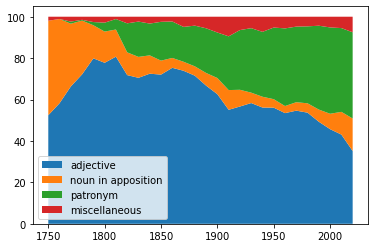

In [106]:
percentages = [
        [subdata[decade] / totals[decade] * 100 for decade in range(1750, 2030, 10)]
        for subdata in data.values()
    ]
plt.stackplot(
    range(1750, 2030, 10),
    *percentages,
    labels=data.keys()
)
plt.legend(loc="lower left")
plt.savefig("buckets.png", format="png")

In [107]:
percentages

[[52.42718446601942,
  58.24175824175825,
  66.32996632996633,
  72.18045112781954,
  79.89690721649485,
  77.75119617224881,
  80.71161048689139,
  71.80327868852459,
  70.49312853678254,
  72.48645394340758,
  72.04130262112788,
  75.32467532467533,
  73.89830508474576,
  71.52385838891739,
  66.71899529042386,
  62.576312576312574,
  55.05050505050505,
  56.63744520976831,
  58.30969937606353,
  56.14730878186969,
  56.083086053412465,
  53.44729344729344,
  54.63821892393321,
  53.669127225358224,
  49.2760392340028,
  45.68784181741691,
  43.08118081180812,
  35.153583617747444],
 [45.63106796116505,
  40.65934065934066,
  30.303030303030305,
  25.93984962406015,
  15.979381443298967,
  15.07177033492823,
  13.108614232209737,
  10.98360655737705,
  10.105092966855295,
  8.85009030704395,
  6.751389992057188,
  4.761904761904762,
  4.350282485875706,
  4.515135967162647,
  6.122448979591836,
  7.814407814407814,
  9.523809523809524,
  8.077645585472762,
  5.0198525241066365,
  5.2

In [108]:
plt.savefig("buckets.png", format="png")

<Figure size 432x288 with 0 Axes>

In [109]:
patronym_data = data["patronym"]
by_sc = defaultdict(lambda: defaultdict(int))
for nam in sc_nams:
    bucket = buckets[nam.species_name_complex.kind]
    if bucket != "patronym":
        continue
    year = nam.numeric_year() // 10 * 10
    if year == 0:
        continue
    by_sc[nam.species_name_complex.label][year] += 1


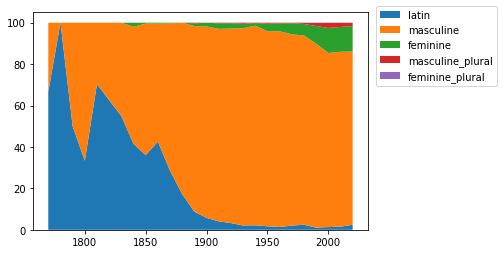

In [115]:
percentages = [
        [subdata[decade] / patronym_data[decade] * 100 for decade in range(1770, 2030, 10)]
        for subdata in by_sc.values()
    ]
plt.stackplot(
    range(1770, 2030, 10),
    *percentages,
    labels=[label[len("patronym_"):] for label in by_sc.keys()]
)
plt.legend(bbox_to_anchor=(1.4, 1.05))
plt.savefig("patronyms.png", format="png", bbox_inches="tight")

In [111]:
percentages

[[66.66666666666666,
  100.0,
  50.0,
  33.33333333333333,
  70.37037037037037,
  62.57309941520468,
  54.976303317535546,
  41.568627450980394,
  36.016949152542374,
  42.62295081967213,
  28.523489932885905,
  17.232375979112273,
  8.73362445414847,
  5.7407407407407405,
  4.077849860982391,
  3.257328990228013,
  2.0947176684881605,
  2.1699819168173597,
  1.7152658662092626,
  1.3677811550151975,
  2.0330368487928845,
  2.453271028037383,
  1.0380622837370241,
  1.3118062563067607,
  1.4823261117445838,
  2.459016393442623],
 [33.33333333333333,
  0.0,
  50.0,
  66.66666666666666,
  29.629629629629626,
  37.42690058479532,
  45.023696682464454,
  56.470588235294116,
  63.559322033898304,
  56.9672131147541,
  71.14093959731544,
  82.76762402088774,
  89.66521106259097,
  92.5,
  92.95644114921224,
  93.91965255157437,
  95.26411657559198,
  96.38336347197107,
  94.16809605488851,
  94.52887537993921,
  92.37611181702668,
  91.35514018691589,
  88.81199538638985,
  84.05650857719476

In [113]:
total_patronyms = bucketed_counts["patronym"]
for key, value in by_sc.items():
    t = sum(value.values())
    print(key, t, t / total_patronyms)

patronym_latin 1025 0.07862841362381098
patronym_masculine 11333 0.8693617674133169
patronym_feminine 569 0.04364835839214483
patronym_masculine_plural 84 0.006443694384780607
patronym_feminine_plural 1 7.671064743786438e-05


In [2]:
from taxonomy.db.models import Person

num_patronyms = {p: len(p.get_sorted_derived_field("patronyms")) for p in Person.select_valid()}

In [5]:
from collections import Counter

num_patronyms = Counter({p: count for p, count in num_patronyms.items() if count > 0})

In [8]:
num_patronyms.most_common(50)

[(<Person: Charles Jean Julien Depéret (1854–1929; French paleontologist; checked; western)>,
  38),
 (<Person: Walter Willis Granger (1872–1941; American paleontologist; checked; western)>,
  17),
 (<Person: George Gaylord Simpson (1902–1984; American paleontologist; checked; western)>,
  17),
 (<Person: Edward Drinker Cope (1840–1897; checked; western)>, 16),
 (<Person: Hans de Bruijn (Dutch paleontologist; checked; dutch)>, 16),
 (<Person: Claude W. Hibbard (1905–1973; American paleontologist; checked; western)>,
  15),
 (<Person: Malcolm Carnegie McKenna (1930–2008; American paleontologist; checked; western)>,
  15),
 (<Person: Pierre Teilhard de Chardin (1881–1955; French Jesuit and paleontologist; checked; western)>,
  15),
 (<Person: Игорь Михайлович Громов (1913–; Russian paleontologist; checked; russian)>,
  15),
 (<Person: Mary R. Dawson (1930–2020; American paleontologist; checked; western)>,
  15),
 (<Person: Sidney Langford Hinde (1863–1930; British colonial administrator;